The models without the sentiment index had the following best results:
- **GRACH(1,1)**:
    - R2: 0.8455
    - RMSE: 1.3763
- **Random Forest** :
    - With all features:
        - R2: 0.8129
        - RMSE: 1.4602
    - Just daily features:
        - R2: 0.8099
        - RMSE: 1.4718
    - Just volatility:
        - R2: 0.8163
        - RMSE: 1.4465
- **Gradient Boosting** :
    - With all features:
        - R2: 0.7929
        - RMSE: 1.5359
    - Just daily features:
        - R2: 0.8240
        - RMSE: 1.4161
    - Just volatility:
        - R2: 0.8255
        - RMSE: 1.4101
- **RNN** :
    - With all features:
        - R2: 0.8355
        - RMSE: 1.3691
            - RMSE lower than GARCH but R2 also lower...
    - Just daily:
        - R2: 0.7937
        - RMSE: 1.5331
    - Daily + inflation:
        - R2: 0.8361
        - RMSE: 1.3667
    - Just volatility:
        - R2: 0.8362
        - RMSE: 1.3659

See that the RNN manages to outperform the GARCH if we look at the RMSE, but the R2 is always lower than the one for GARCH...

Now, we want to add the sentiment index to our models and see if it improves it. 

### Models with sentiment:

#### First: need to create the dataframes:

In [13]:
#Necessary libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
#start with the historical numercial data stuff:

#Get volatility historical data:

url_volatility = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/volatility_data.csv'
volatility_df = pd.read_csv(url_volatility)
#make the date a datetime object:
volatility_df['Date'] = pd.to_datetime(volatility_df['Date'])

url_nasdaq_price = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/Nasdaq100_price_data.csv'
price_df = pd.read_csv(url_nasdaq_price)
price_df['Date'] = pd.to_datetime(price_df['Date'])
#this dataset includes the prices and the volume!
# we now need to calculate the returns, do this by taking the logarithm and first difference of the closing price.
price_df['Log_Returns'] = np.log(price_df['Close']).diff()*100

#drop 2014-12-31 from the data:
price_df = price_df[price_df['Date'] > '2014-12-31']

# CPI data:
url_cpi = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/us_cpi_dec2014to2019.csv'
cpi_df = pd.read_csv(url_cpi)

# add monthly inflation rates (log difference like the returns)
# - not sure if log-diff is the best approach for inflation but maybe makes sense for consistency at least?

cpi_df['Log_inflation'] = np.log(cpi_df['CPIAUCSL']).diff()*100

cpi_df.head()

#now, the data is monthly but we want it to be daily, 
# so we want to extend it and just keep the same values for every day of each month:

cpi_df['DATE'] = pd.to_datetime(cpi_df['DATE'])

# Filter out the first month (December 2014)
df_filtered = cpi_df[cpi_df['DATE'] > '2014-12-01']

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in df_filtered.iterrows():
    # Get the first and last day of the month
    start_date = row['DATE']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'DATE': date_range,
        'CPIAUCSL': row['CPIAUCSL'],
        'Log_inflation': row['Log_inflation']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)

cpi_daily_data = daily_data

# interest rates data

url_ir = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/US_interest_rates_historical.csv'
ir_df = pd.read_csv(url_ir)

#now, the data is monthly but we want it to be daily, 
# so we want to extend it and just keep the same values for every day of each month:

#make the date a datetime object:
ir_df['DATE'] = pd.to_datetime(ir_df['DATE'])

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in ir_df.iterrows():
    # Get the first and last day of the month
    start_date = row['DATE']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'DATE': date_range,
        'interest_rate': row['INTDSRUSM193N']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)
ir_daily_data = daily_data

#get consumer confidence data:
cci_url = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/consumer_barometer_US2015to2019.csv'

cci_df = pd.read_csv(cci_url)

cci_df = pd.DataFrame({'Date': cci_df['TIME_PERIOD'],
                      'consumer_barometer': cci_df['OBS_VALUE']})

cci_df['Date'] = pd.to_datetime(cci_df['Date'])

#make it daily:

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in cci_df.iterrows():
    # Get the first and last day of the month
    start_date = row['Date']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'Date': date_range,
        'consumer_barometer': row['consumer_barometer']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)

cci_daily_data = daily_data

# merge the datasets and keep only the columns of interest:

# Assuming volatility_df, price_df, cpi_daily_data, ir_daily_data, cci_daily_data are already defined

# Step 1: Standardize Date Column Names
cpi_daily_data.rename(columns={'DATE': 'Date'}, inplace=True)
ir_daily_data.rename(columns={'DATE': 'Date'}, inplace=True)

# Step 2: Merge DataFrames
# Merge volatility_df and price_df
merged_df = pd.merge(volatility_df[['Date', 'Price']], 
                     price_df[['Date', 'Log_Returns', 'Volume']], 
                     on='Date', 
                     how='inner')

# Merge with cpi_daily_data
merged_df = pd.merge(merged_df, 
                     cpi_daily_data[['Date', 'Log_inflation']], 
                     on='Date', 
                     how='inner')

# Merge with ir_daily_data
merged_df = pd.merge(merged_df, 
                     ir_daily_data[['Date', 'interest_rate']], 
                     on='Date', 
                     how='inner')

# Merge with cci_daily_data
merged_df = pd.merge(merged_df, 
                     cci_daily_data[['Date', 'consumer_barometer']], 
                     on='Date', 
                     how='inner')

# merged_df now contains all the desired columns with matching dates

#rename 'Price' to 'Volatility' and more relevant column names:
merged_df.rename(columns={'Price' : 'Volatility', 'Log_Returns' : 'stock_log_returns', 'Volume':'stock_volume', 'Log_inflation':'US_log_inflation', 'interest_rate':'US_interest_rate'}, inplace = True)

#now, the first date in the dataframe is 30-12-2019, and it goes back to 2015, but we would rather
# start from the oldest date and go to the newest so we have to reverse the order of the rows:

merged_df = merged_df.iloc[::-1]

merged_df.head()

,Date,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
1256,2015-01-02,16.59,-0.142669,1435150000,-0.639069,0.75,0.353886
1255,2015-01-05,18.00,-1.651298,1794470000,-0.639069,0.75,0.353886
1254,2015-01-06,19.05,-1.212083,2167320000,-0.639069,0.75,0.353886
1253,2015-01-07,17.20,1.189010,1957950000,-0.639069,0.75,0.353886
1252,2015-01-08,16.61,1.917786,2105450000,-0.639069,0.75,0.353886


##### Next: get the sentiment index:

In [5]:
import requests
from io import BytesIO
from typing import List

def load_and_merge_csv_xz_from_github(years: List[int], companies: List[str], base_url: str) -> pd.DataFrame:
    all_dataframes = []
    
    for year in years:
        for company in companies:
            filename = f"df_{year}_{company}.csv.xz"
            file_url = f"{base_url}/{filename}"
            
            response = requests.get(file_url)
            if response.status_code == 200:
                file_content = BytesIO(response.content)
                df = pd.read_csv(file_content, compression='xz')
                all_dataframes.append(df)

    merged_dataframe = pd.concat(all_dataframes, ignore_index=True)

    # Sort dataframe by date
    df_sorted = merged_dataframe.sort_values(by='post_date')

    # Remove the 'Unnamed: 0' column
    df_sorted = df_sorted.drop(columns=['Unnamed: 0'])
    
    # Drop 'year' columns that was used previously to split dataframes and save them as smaller csv files 
    df_sorted = df_sorted.drop(columns=['year'])


    # Reset the index of the dataframe and drop the old one
    df_sorted = df_sorted.reset_index(drop=True)

    return df_sorted

    
base_url = "https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data"
years = [2015, 2016, 2017, 2018, 2019]
companies = ['AAPL', 'AMZN', 'GOOGL', 'TSLA', 'GOOG', 'MSFT']
tweets_df = load_and_merge_csv_xz_from_github(years, companies, base_url)


In [6]:
import re

def filter_tweets_v7(df):
    df = df.copy()

    print("Initial dataset length:", len(df))

    # Normalize URLs in the tweet bodies - replace with "URL" or remove
    df['body'] = df['body'].apply(lambda text: re.sub(r'http\S+', 'URL', text))

    # Remove all duplicates based on 'tweet_id' and 'ticker_symbol' (seen as spam)
    df.drop_duplicates(subset=['tweet_id', 'ticker_symbol'], inplace=True, keep = False)
    print("After removing duplicate tweet_ids and ticker_symbols:", len(df))

    # Remove last duplicates based on 'tweet_id' and 'company_name'(will only apply to Google as they have different ticker_symbols)
    df.drop_duplicates(subset=['tweet_id', 'company_name'], inplace=True, keep = 'first')
    print("After removing duplicate tweet_ids and company_names (Google):", len(df))

    # Remove tweets with duplicate texts longer than 5 words considering the ticker symbol
    df['word_count'] = df['body'].apply(lambda text: len(text.split()))
    duplicates = df[(df['word_count'] > 5)].duplicated(subset=['body', 'ticker_symbol'], keep=False)
    df = df.loc[~df.index.isin(duplicates[duplicates].index)]
    print("After removing long duplicate texts:", len(df))

    # Apply counting functions
    df['hashtag_count'] = df['body'].apply(lambda text: sum(1 for word in text.split() if word.startswith('#')))
    df['cashtag_count'] = df['body'].apply(lambda text: sum(1 for word in text.split() if word.startswith('$')))
    df['mention_count'] = df['body'].apply(lambda text: sum(1 for word in text.split() if word.startswith('@')))

    # Filter tweets based on hashtag and cashtag counts
    df = df[(df['cashtag_count'] < 5) & (df['hashtag_count'] < 8)]
    print("After filtering by cashtags and hashtags:", len(df))

    # Ratio filters (cashtags, hashtags, mentions to words)
    df['cashtag_ratio'] = df['cashtag_count'] / df['word_count'].replace(0, 1)
    df['hashtag_ratio'] = df['hashtag_count'] / df['word_count'].replace(0, 1)
    df['mention_ratio'] = df['mention_count'] / df['word_count'].replace(0, 1)
    df = df[(df['cashtag_ratio'] <= 0.5) & (df['hashtag_ratio'] <= 0.5) & (df['mention_ratio'] <= 0.5)]
    print("After filtering by ratios:", len(df))

    # Keyword filter (defined by Wilksch, Abramova (2023) PyFin-sentiment: Towards a machine-learning-based model for deriving sentiment from financial tweets)
    keywords = ['bitcoin', 'etherium', 'btc', 'eth', 'nft', 'token', 'wallet', 'web3',
                'airdrop', 'wagmi', 'solana', 'opensea', 'cryptopunks', 'uniswap', 
                'lunar', 'hodl', 'binance', 'coinbase', 'cryptocom', 'doge']
    df['keyword_count'] = df['body'].apply(lambda text: sum(text.lower().count(kw) for kw in keywords))
    df = df[df['keyword_count'] <= 2]
    print("After filtering by keyword count:", len(df))

    return df


filtered_df_7 = filter_tweets_v7(tweets_df)


Initial dataset length: 4336445
After removing duplicate tweet_ids and ticker_symbols: 4336445
After removing duplicate tweet_ids and company_names (Google): 4288706
After removing long duplicate texts: 3196398
After filtering by cashtags and hashtags: 2529106
After filtering by ratios: 2508943
After filtering by keyword count: 2508222


In [7]:
import pandas as pd

def check_empty_bodies(df):
    # Check for empty or NaN entries in the 'body' column
    empty_bodies = df['body'].isna() | (df['body'] == '')
    
    # Count the number of empty or NaN entries
    empty_count = empty_bodies.sum()
    
    # Print the results
    if empty_count > 0:
        print(f"There are {empty_count} empty 'body' cells in the DataFrame.")
    else:
        print("There are no empty 'body' cells in the DataFrame.")

    # Optionally, you might want to return a DataFrame with the empty entries for review
    empty_entries = df[empty_bodies]
    return empty_entries

In [8]:
# limit magnitude of preparation as it doesn't seem to be necessary according to example in pyfin documentation
import re

def preprocess_text_column(df):
    df = df.copy()  # Create a copy to avoid modifying the original DataFrame

    def transform_text(text):
        # Replace cashtags with 'TICKER'
        # text = re.sub(r'\$\w+', 'TICKER', text)
        
        # Replace mentions with '@user'
        text = re.sub(r'@\w+', '@user', text)
        
        # Replace all digits with '9'
        # text = re.sub(r'\d', '9', text)
        
        # Replace newlines with spaces
        text = text.replace('\n', ' ')
        
        # Convert to lowercase
        text = text.lower()

        # Remove repeated characters more than twice
        text = re.sub(r'(.)\1{2,}', r'\1', text)
        
        return text

    # Apply the transformation to the 'body' column
    df['body'] = df['body'].apply(transform_text)
    
    return df

# Preprocess text column
preprocessed_df = preprocess_text_column(filtered_df_7)


In [9]:
# WARNINGS CAN BE IGNORED (PROOF THROUGH COMPARING SENTIMENT LABELS OBTAINED BY 1.1.1 AND 1.3.0)
from pyfin_sentiment.model import SentimentModel
import numpy as np

# Initialize the sentiment model
# SentimentModel.download("small")  # This line is commented because it's assumed the model is already downloaded
model = SentimentModel("small")

def apply_batch_sentiment(texts, batch_size=1000):
    # Initialize an empty list to store sentiment results
    sentiments = []
    
    # Process texts in batches
    total_texts = len(texts)
    for i in range(0, total_texts, batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_predictions = model.predict(batch_texts)
        sentiments.extend(batch_predictions)
        
        # Print progress
        processed = min(i + batch_size, total_texts)
        print(f"Processed {processed}/{total_texts} texts")
    
    return sentiments

# Assume preprocessed_df is your DataFrame and has already been defined
# Apply sentiment analysis in batches to the 'body' column and store the results in a new column
preprocessed_df['sentiment'] = apply_batch_sentiment(preprocessed_df['body'].tolist(), batch_size=1000)

# Now the DataFrame preprocessed_df includes a new column 'sentiment' with sentiment labels


Processed 1000/2508222 texts
Processed 2000/2508222 texts
Processed 3000/2508222 texts
Processed 4000/2508222 texts
Processed 5000/2508222 texts
Processed 6000/2508222 texts
Processed 7000/2508222 texts
Processed 8000/2508222 texts
Processed 9000/2508222 texts
Processed 10000/2508222 texts
Processed 11000/2508222 texts
Processed 12000/2508222 texts
Processed 13000/2508222 texts
Processed 14000/2508222 texts
Processed 15000/2508222 texts
Processed 16000/2508222 texts
Processed 17000/2508222 texts
Processed 18000/2508222 texts
Processed 19000/2508222 texts
Processed 20000/2508222 texts
Processed 21000/2508222 texts
Processed 22000/2508222 texts
Processed 23000/2508222 texts
Processed 24000/2508222 texts
Processed 25000/2508222 texts
Processed 26000/2508222 texts
Processed 27000/2508222 texts
Processed 28000/2508222 texts
Processed 29000/2508222 texts
Processed 30000/2508222 texts
Processed 31000/2508222 texts
Processed 32000/2508222 texts
Processed 33000/2508222 texts
Processed 34000/250

In [10]:
# Replace sentiment values so we can compute their average

# Convert the 'sentiment' column to integer
preprocessed_df['sentiment'] = preprocessed_df['sentiment'].astype(int)

# Define the mapping of old values to new values
replacement_map = {2: 0, 3: -1}

# Replace the values in the 'sentiment' column
preprocessed_df['sentiment'] = preprocessed_df['sentiment'].replace(replacement_map)

preprocessed_df.head(n=2)

,ticker_symbol,company_name,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,word_count,hashtag_count,cashtag_count,mention_count,cashtag_ratio,hashtag_ratio,mention_ratio,keyword_count,sentiment
1,AAPL,apple,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,insanity of today weirdo massive selling. $aap...,0,0,0,20,0,1,0,0.050000,0.0,0.000000,0,-1
3,TSLA,Tesla Inc,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$gm $tsla: volkswagen pushes 2014 record recal...,0,0,1,13,0,2,2,0.153846,0.0,0.153846,0,1


In [11]:
# Add weighted interactions columns (likes: 1.5, comments: 2, retweets: 3)
# Add +1 so the weights don't become 0 (would lead to sparse dataset as most tweets actually have zero interaction) 
preprocessed_df['weighted_interactions'] = 1.5*preprocessed_df['like_num'] + 2*preprocessed_df['comment_num'] + 3*preprocessed_df['retweet_num'] + 1


In [12]:
# Convert post_date to datetime object and add column that only contains date (not time)

# type(preprocessed_df['post_date'])

preprocessed_df['post_date'] = pd.to_datetime(preprocessed_df['post_date'])

preprocessed_df['date_only'] = preprocessed_df['post_date'].dt.date
preprocessed_df['weekday'] = preprocessed_df['post_date'].dt.day_of_week

# Create new data frame grouped by date and company

# Group by 'company_name' and 'post_date', then calculate the average sentiment
grouped_df = preprocessed_df.groupby(['date_only', 'weekday', 'company_name'])['sentiment'].mean().reset_index()

# Rename the column for clarity
grouped_df.rename(columns={'sentiment': 'average_sentiment'}, inplace=True)
grouped_df.rename(columns={'date_only': 'date'}, inplace=True)
grouped_df['date'] = pd.to_datetime(grouped_df['date'])


c:\Users\ingam\anaconda3\lib\site-packages\pandas\core\dtypes\astype.py:189: RuntimeWarning: invalid value encountered in cast
  return values.astype(dtype, copy=copy)


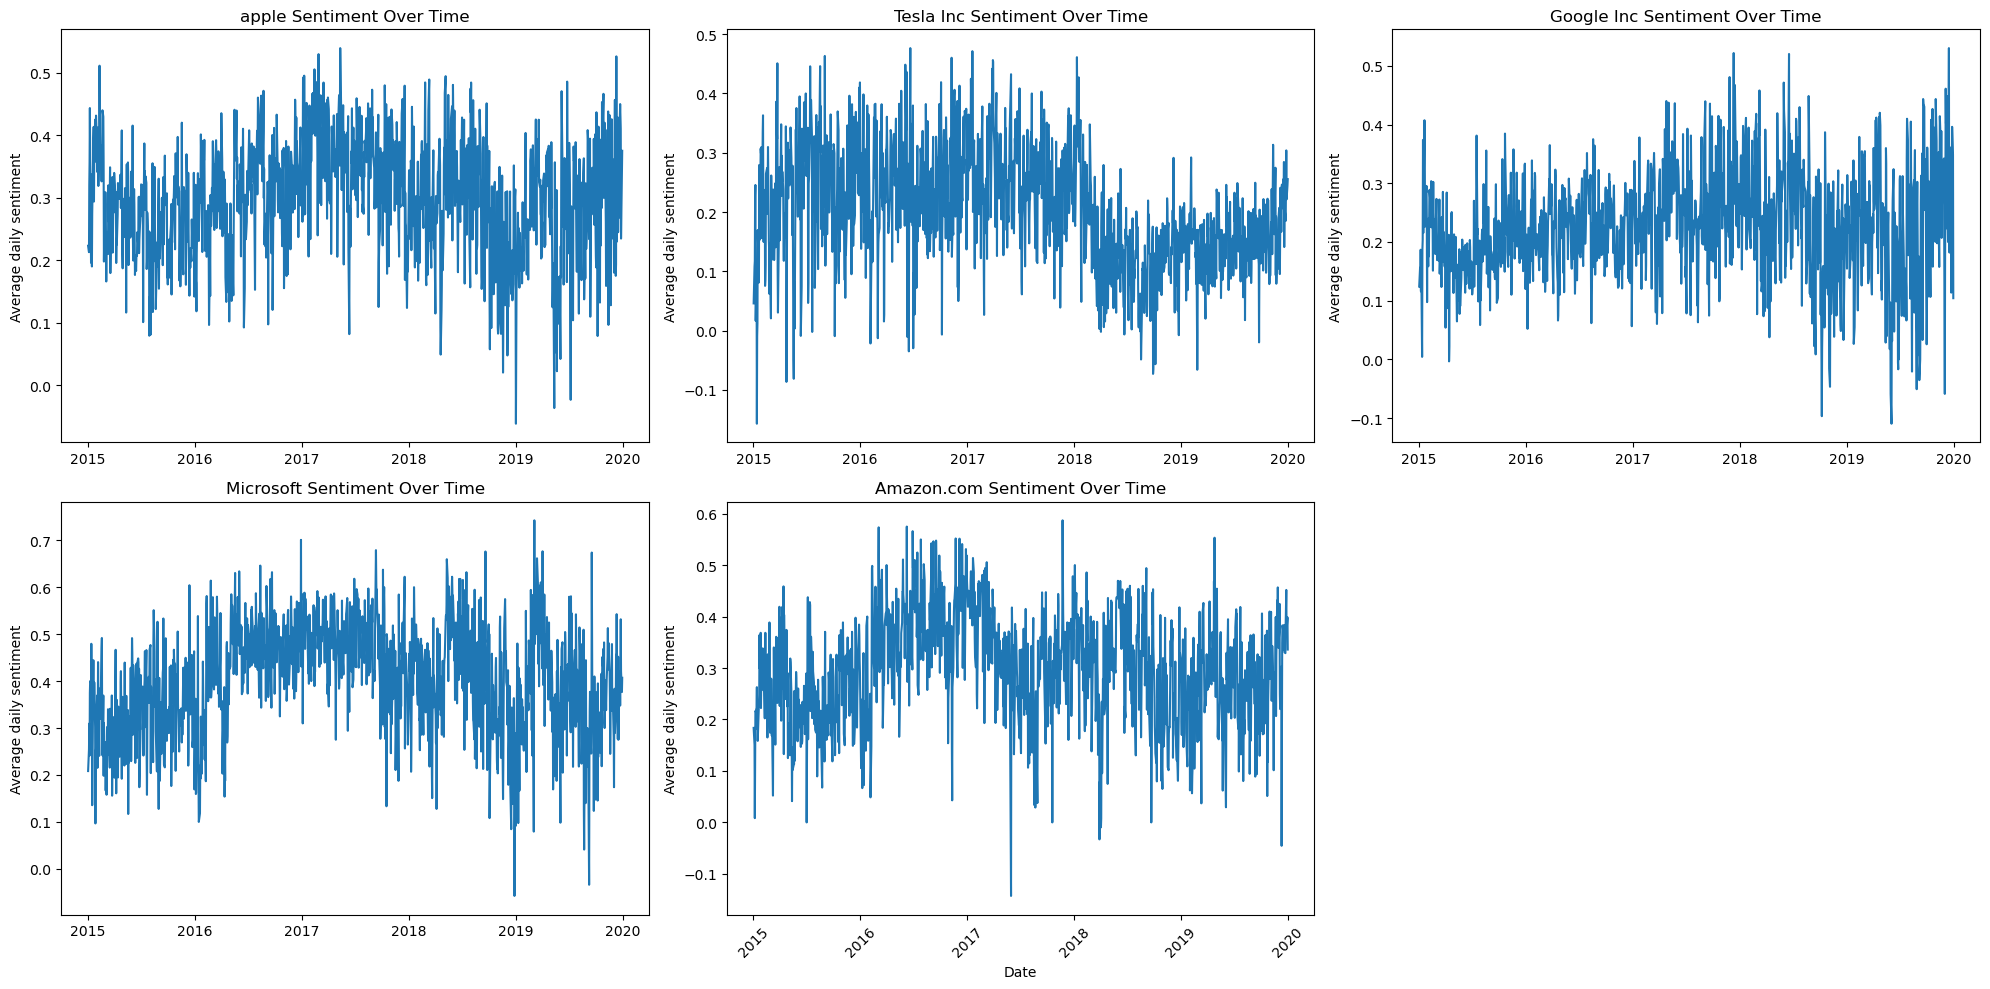

In [13]:
# Load market cap file

market_cap_path = "https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/market_cap/total_market_cap_2015-2019.xlsx"

market_cap_df = pd.read_excel(market_cap_path).sort_values("date")

market_cap_df['date'] = pd.to_datetime(market_cap_df['date'])

market_cap_df['weights_abs'] = market_cap_df['weights_abs'].astype(int)

market_cap_df['weights_rel'] = market_cap_df.groupby('date')['weights_abs'].transform(lambda x: x / x.sum())

# replace company ticker by company name for a smooth join

replacements = {"AAPL.O": "apple", "AMZN.O": "Amazon.com", "GOOG.O": "Google Inc", "MSFT.O": "Microsoft", "TSLA.O": "Tesla Inc"}

market_cap_df['company_ticker'] = market_cap_df['company_ticker'].replace(replacements)

market_cap_df.rename(columns={'company_ticker': 'company_name'}, inplace=True)

# join market_cap_df and grouped_df by date

sentiment_df = pd.merge(market_cap_df, grouped_df, on=['date', 'weekday', 'company_name'])

# Compute unweighted sentiment index
sentiment_index_unweighted_df = sentiment_df.groupby('date')['average_sentiment'].mean().reset_index()
sentiment_index_unweighted_df.columns = ['date', 'average_daily_sentiment']

# Calculate the weighted average of sentiment per day
sentiment_index_df = sentiment_df.groupby('date').apply(
    lambda x: pd.Series({
        'weighted_sentiment': (x['weights_rel'] * x['average_sentiment']).sum()
    })
).reset_index()

#Get unique list of companies
companies = sentiment_df['company_name'].unique()

# Set up the matplotlib figure and axes
#fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

plt.figure(figsize=(20,10))
# Plot each company's data on a separate subplot
for i, company in enumerate(companies):
    # Filter the DataFrame for the current company
    data = sentiment_df[sentiment_df['company_name'] == company]
    
    # Plot on ith subplot
    plt.subplot(2,3,i+1)
    plt.plot(data['date'], data['average_sentiment'], label=f'{company} Sentiment')
    plt.title(f'{company} Sentiment Over Time')
    plt.ylabel('Average daily sentiment')
    
# Set common labels
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [14]:
sentiment_index_df.rename(columns={'date':'Date'}, inplace=True)
sentiment_index_df.head()

,Date,weighted_sentiment
0,2015-01-02,0.157043
1,2015-01-05,0.176534
2,2015-01-06,0.175732
3,2015-01-07,0.221803
4,2015-01-08,0.279241


#### Now, we've loaded all the data so just have to add the sentiment to the merged_df dataframe:

In [15]:
merged_df = pd.merge(merged_df, 
                     sentiment_index_df[['Date', 'weighted_sentiment']], 
                     on='Date', 
                     how='inner')
merged_df.head()

,Date,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer,weighted_sentiment
0,2015-01-02,16.59,-0.142669,1435150000,-0.639069,0.75,0.353886,0.157043
1,2015-01-05,18.00,-1.651298,1794470000,-0.639069,0.75,0.353886,0.176534
2,2015-01-06,19.05,-1.212083,2167320000,-0.639069,0.75,0.353886,0.175732
3,2015-01-07,17.20,1.189010,1957950000,-0.639069,0.75,0.353886,0.221803
4,2015-01-08,16.61,1.917786,2105450000,-0.639069,0.75,0.353886,0.279241


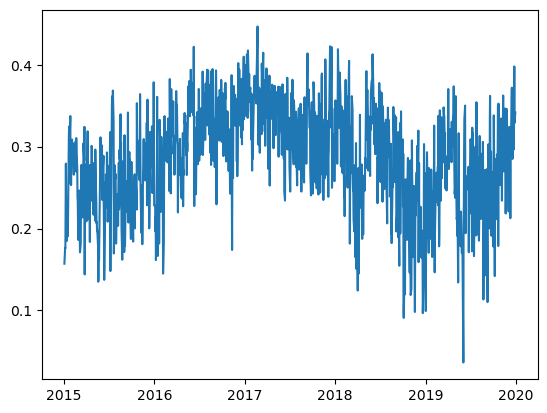

In [16]:
plt.plot(merged_df['Date'], merged_df['weighted_sentiment'])

Now, we again want to look at the lag1 of all the features, so X_train will contain the lag1 of all the features and y_train the volatility today (not lagged), and same for X_test & y_test:

In [17]:
#Creating Lagged Features
lags = 1  # Number of lags
for column in merged_df.columns.drop('Date'):
    for lag in range(1, lags + 1):
        merged_df[f'{column}_lag{lag}'] = merged_df[column].shift(lag)

# Dropping rows with NaN values after shifting
merged_df.dropna(inplace=True)

merged_df.head()

,Date,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer,weighted_sentiment,Volatility_lag1,stock_log_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1,weighted_sentiment_lag1
1,2015-01-05,18.00,-1.651298,1794470000,-0.639069,0.75,0.353886,0.176534,16.59,-0.142669,1.435150e+09,-0.639069,0.75,0.353886,0.157043
2,2015-01-06,19.05,-1.212083,2167320000,-0.639069,0.75,0.353886,0.175732,18.00,-1.651298,1.794470e+09,-0.639069,0.75,0.353886,0.176534
3,2015-01-07,17.20,1.189010,1957950000,-0.639069,0.75,0.353886,0.221803,19.05,-1.212083,2.167320e+09,-0.639069,0.75,0.353886,0.175732
4,2015-01-08,16.61,1.917786,2105450000,-0.639069,0.75,0.353886,0.279241,17.20,1.189010,1.957950e+09,-0.639069,0.75,0.353886,0.221803
5,2015-01-09,16.60,-0.645154,1715830000,-0.639069,0.75,0.353886,0.231713,16.61,1.917786,2.105450e+09,-0.639069,0.75,0.353886,0.279241


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [19]:
#create X_train, y_train, X_test and y_test:
X_train, X_test, y_train, y_test = train_test_split(merged_df.loc[:, merged_df.columns != 'Date'], merged_df['Volatility'], test_size=0.2, shuffle=False)
X_train = X_train[['Volatility_lag1','stock_log_returns_lag1', 
                       'stock_volume_lag1', 'US_log_inflation_lag1',
                       'US_interest_rate_lag1', 'consumer_barometer_lag1', 'weighted_sentiment_lag1']]

X_test = X_test[['Volatility_lag1','stock_log_returns_lag1', 
                       'stock_volume_lag1', 'US_log_inflation_lag1',
                       'US_interest_rate_lag1', 'consumer_barometer_lag1', 'weighted_sentiment_lag1']]

X_train.head()

,Volatility_lag1,stock_log_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1,weighted_sentiment_lag1
1,16.59,-0.142669,1.435150e+09,-0.639069,0.75,0.353886,0.157043
2,18.00,-1.651298,1.794470e+09,-0.639069,0.75,0.353886,0.176534
3,19.05,-1.212083,2.167320e+09,-0.639069,0.75,0.353886,0.175732
4,17.20,1.189010,1.957950e+09,-0.639069,0.75,0.353886,0.221803
5,16.61,1.917786,2.105450e+09,-0.639069,0.75,0.353886,0.279241


#### Now we have all the data ready, so we can try modeling:

### Modeling with the sentiment:

#### 1. Tree based methods:

In [21]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV

In [21]:
# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(70,80), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(75,85), 'learning_rate': np.linspace(0.08,0.12,10), 'max_depth': [1, 2, 3]}
}

# Storing model performance
model_performance = {}
model_predictions = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring='neg_mean_squared_error')
    param_search.fit(X_train, y_train)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_performance[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance)

Model:   Random Forest
{'n_estimators': range(70, 80), 'max_depth': range(1, 5)}
RandomForestRegressor(max_depth=4, n_estimators=75, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(75, 85), 'learning_rate': array([0.08      , 0.08444444, 0.08888889, 0.09333333, 0.09777778,
       0.10222222, 0.10666667, 0.11111111, 0.11555556, 0.12      ]), 'max_depth': [1, 2, 3]}
GradientBoostingRegressor(learning_rate=0.10222222222222221, max_depth=2,
                          n_estimators=78, random_state=42)
{'Random Forest': {'RMSE': 1.4817456224683518, 'R2': 0.8072921628918729, 'Best Params': {'n_estimators': 75, 'max_depth': 4}}, 'Gradient Boosting': {'RMSE': 1.581545726711112, 'R2': 0.7804590306698329, 'Best Params': {'n_estimators': 78, 'max_depth': 2, 'learning_rate': 0.10222222222222221}}}


In [22]:
# Extract model prediction values for random forest, AdaBoost and gradient boosting:

y_pred_rf = model_predictions['Random Forest']['y_pred']
#y_pred_ab = model_predictions['AdaBoost']['y_pred']
y_pred_gb = model_predictions['Gradient Boosting']['y_pred']

r2_rf = model_performance['Random Forest']['R2']
#r2_ab = model_performance['AdaBoost']['R2']
r2_gb = model_performance['Gradient Boosting']['R2']

rmse_rf = model_performance['Random Forest']['RMSE']
#rmse_ab = model_performance['AdaBoost']['RMSE']
rmse_gb = model_performance['Gradient Boosting']['RMSE']

compare_performance = {'Random Forest': f'R2: {r2_rf}, RMSE: {rmse_rf}',
                       #'AdaBoost': f'R2: {r2_ab}, RMSE: {rmse_ab}',
                       'Gradient Boosting': f'R2: {r2_gb}, RMSE: {rmse_gb}',
}

model_names = ['Random Forest', 'Gradient Boosting']

for model in model_names:
    print(model, ':', compare_performance[model])
    

Random Forest : R2: 0.8072921628918729, RMSE: 1.4817456224683518
Gradient Boosting : R2: 0.7804590306698329, RMSE: 1.581545726711112


In [23]:
#dates for test data:
test_dates = merged_df['Date'].tail(252)

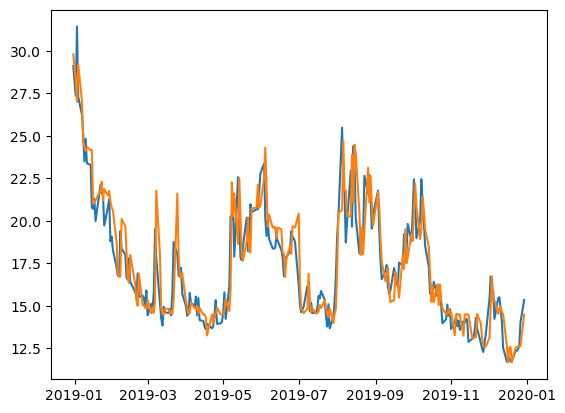

In [24]:
#plot prediction vs actual over time:
plt.plot(test_dates, y_test)
plt.plot(test_dates, y_pred_rf)
plt.show()

In [25]:
#Take just volatility + sentiment:
X_train2 = X_train[['Volatility_lag1', 'weighted_sentiment_lag1']]
X_test2 = X_test[['Volatility_lag1', 'weighted_sentiment_lag1']]

X_train2.head()

,Volatility_lag1,weighted_sentiment_lag1
1,16.59,0.157043
2,18.00,0.176534
3,19.05,0.175732
4,17.20,0.221803
5,16.61,0.279241


In [26]:
# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(70,80), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(75,85), 'learning_rate': np.linspace(0.08,0.12,10), 'max_depth': [1, 2, 3]}
}

# Storing model performance
model_performance = {}
model_predictions = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring='neg_mean_squared_error')
    param_search.fit(X_train2, y_train)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test2)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_performance[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance)

Model:   Random Forest
{'n_estimators': range(70, 80), 'max_depth': range(1, 5)}
RandomForestRegressor(max_depth=4, n_estimators=71, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(75, 85), 'learning_rate': array([0.08      , 0.08444444, 0.08888889, 0.09333333, 0.09777778,
       0.10222222, 0.10666667, 0.11111111, 0.11555556, 0.12      ]), 'max_depth': [1, 2, 3]}
GradientBoostingRegressor(learning_rate=0.10666666666666666, max_depth=1,
                          n_estimators=80, random_state=42)
{'Random Forest': {'RMSE': 1.4356674585392775, 'R2': 0.8190911618473883, 'Best Params': {'n_estimators': 71, 'max_depth': 4}}, 'Gradient Boosting': {'RMSE': 1.4100383903205758, 'R2': 0.8254925608061856, 'Best Params': {'n_estimators': 80, 'max_depth': 1, 'learning_rate': 0.10666666666666666}}}


In [27]:
# Extract model prediction values for random forest, AdaBoost and gradient boosting:

y_pred_rf = model_predictions['Random Forest']['y_pred']
y_pred_gb = model_predictions['Gradient Boosting']['y_pred']

r2_rf = model_performance['Random Forest']['R2']
r2_gb = model_performance['Gradient Boosting']['R2']

rmse_rf = model_performance['Random Forest']['RMSE']
rmse_gb = model_performance['Gradient Boosting']['RMSE']

compare_performance = {'Random Forest': f'R2: {r2_rf}, RMSE: {rmse_rf}',
                       'Gradient Boosting': f'R2: {r2_gb}, RMSE: {rmse_gb}',
}

model_names = ['Random Forest', 'Gradient Boosting']

for model in model_names:
    print(model, ':', compare_performance[model])
    

Random Forest : R2: 0.8190911618473883, RMSE: 1.4356674585392775
Gradient Boosting : R2: 0.8254925608061856, RMSE: 1.4100383903205758


Best random forest results so far!
Try rolling window:

In [28]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning (simplified for rolling window example)
parameters = {
    "Random Forest": {'n_estimators': 71, 'max_depth': 4}, 
    "Gradient Boosting": {'n_estimators': 84, 'max_depth': 1, 'learning_rate': 0.12}
}

# Initialize dictionaries to store results
model_performance2 = {}
model_predictions2 = {}

# Window size
window_size = 252  # days -> 252 is the number of days in the data / 5 (so ~the number of days per year of the data)

# Implementing rolling window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    actuals = y_test.copy()  # assuming y_test is your out-of-sample data

    # Start rolling window forecast
    for i in range(len(X_test2)):  # assuming X_test_lags is the test set features
        # Define the start point for the training window
        start_point = max(0, len(X_train2) + i - window_size)
        end_point = len(X_train2) + i

        # Train model on current window data
        X_train_rolling = pd.concat([pd.DataFrame(X_train2), pd.DataFrame(X_test2).iloc[:i]]).iloc[start_point:end_point]
        y_train_rolling = pd.concat([y_train, y_test.iloc[:i]]).iloc[start_point:end_point]
        
        # Fit the model with the best parameters (simplified for demo)
        model.set_params(**params)
        model.fit(X_train_rolling, y_train_rolling)
        
        # Make a prediction for the next point
        next_point_prediction = model.predict(pd.DataFrame(X_test2).iloc[[i]])
        predictions.append(next_point_prediction[0])
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions2[model_name] = {'y_pred': predictions}

# Output model performance
print(model_performance2)


Model:   Random Forest
Model:   Gradient Boosting
{'Random Forest': {'RMSE': 1.4832451826532767, 'R2': 0.8069019161165748}, 'Gradient Boosting': {'RMSE': 1.4616616069051016, 'R2': 0.812480796122498}}


got worse???? idk why

#### RNN:

Epoch 1/150
16/16 [==============================] - 6s 8ms/step - loss: 261.1941
Epoch 2/150
16/16 [==============================] - 0s 8ms/step - loss: 235.3668
Epoch 3/150
16/16 [==============================] - 0s 8ms/step - loss: 109.1867
Epoch 4/150
16/16 [==============================] - 0s 9ms/step - loss: 36.9565
Epoch 5/150
16/16 [==============================] - 0s 9ms/step - loss: 26.2507
Epoch 6/150
16/16 [==============================] - 0s 8ms/step - loss: 23.8596
Epoch 7/150
16/16 [==============================] - 0s 11ms/step - loss: 21.0896
Epoch 8/150
16/16 [==============================] - 0s 10ms/step - loss: 14.9968
Epoch 9/150
16/16 [==============================] - 0s 9ms/step - loss: 12.7666
Epoch 10/150
16/16 [==============================] - 0s 9ms/step - loss: 10.9732
Epoch 11/150
16/16 [==============================] - 0s 11ms/step - loss: 10.6697
Epoch 12/150
16/16 [==============================] - 0s 8ms/step - loss: 11.5026
Epoch 13/150
16/16 

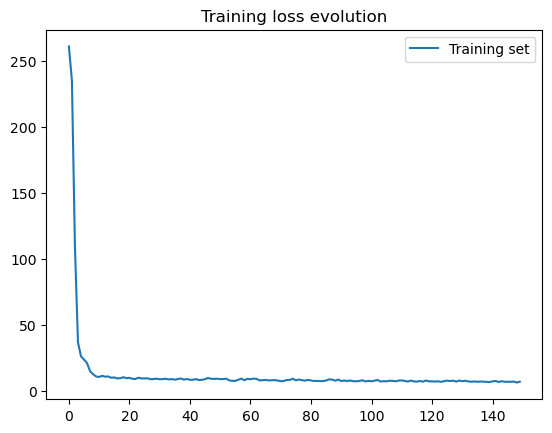

8/8 [==============================] - 1s 4ms/step
RMSE: 1.3937954285624592 R2: 0.8294898867555097


In [30]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
import keras

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train2)
X_test_daily_scaled = scaler.transform(X_test2)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(GRU(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


Epoch 1/150
16/16 [==============================] - 5s 11ms/step - loss: 262.4285
Epoch 2/150
16/16 [==============================] - 0s 11ms/step - loss: 240.3754
Epoch 3/150
16/16 [==============================] - 0s 11ms/step - loss: 108.3375
Epoch 4/150
16/16 [==============================] - 0s 11ms/step - loss: 41.6641
Epoch 5/150
16/16 [==============================] - 0s 11ms/step - loss: 35.5282
Epoch 6/150
16/16 [==============================] - 0s 11ms/step - loss: 29.7825
Epoch 7/150
16/16 [==============================] - 0s 11ms/step - loss: 31.0867
Epoch 8/150
16/16 [==============================] - 0s 12ms/step - loss: 31.0627
Epoch 9/150
16/16 [==============================] - 0s 11ms/step - loss: 26.9618
Epoch 10/150
16/16 [==============================] - 0s 13ms/step - loss: 26.3682
Epoch 11/150
16/16 [==============================] - 0s 12ms/step - loss: 26.1851
Epoch 12/150
16/16 [==============================] - 0s 12ms/step - loss: 21.0565
Epoch 13/1

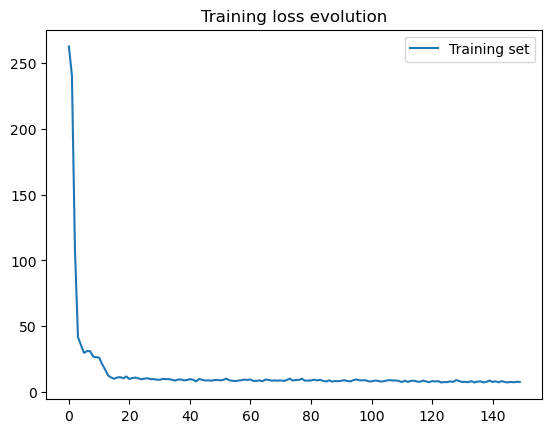

8/8 [==============================] - 1s 4ms/step
RMSE: 1.3618954143010298 R2: 0.8372055531497682


In [51]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
import keras

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train)
X_test_daily_scaled = scaler.transform(X_test)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(GRU(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


Epoch 1/150
16/16 [==============================] - 7s 12ms/step - loss: 261.5130
Epoch 2/150
16/16 [==============================] - 0s 10ms/step - loss: 230.6151
Epoch 3/150
16/16 [==============================] - 0s 10ms/step - loss: 80.3312
Epoch 4/150
16/16 [==============================] - 0s 10ms/step - loss: 38.5405
Epoch 5/150
16/16 [==============================] - 0s 10ms/step - loss: 31.0965
Epoch 6/150
16/16 [==============================] - 0s 15ms/step - loss: 29.1867
Epoch 7/150
16/16 [==============================] - 0s 8ms/step - loss: 27.6582
Epoch 8/150
16/16 [==============================] - 0s 9ms/step - loss: 25.1318
Epoch 9/150
16/16 [==============================] - 0s 11ms/step - loss: 22.8036
Epoch 10/150
16/16 [==============================] - 0s 15ms/step - loss: 20.1051
Epoch 11/150
16/16 [==============================] - 0s 17ms/step - loss: 15.6894
Epoch 12/150
16/16 [==============================] - 0s 10ms/step - loss: 12.8976
Epoch 13/150


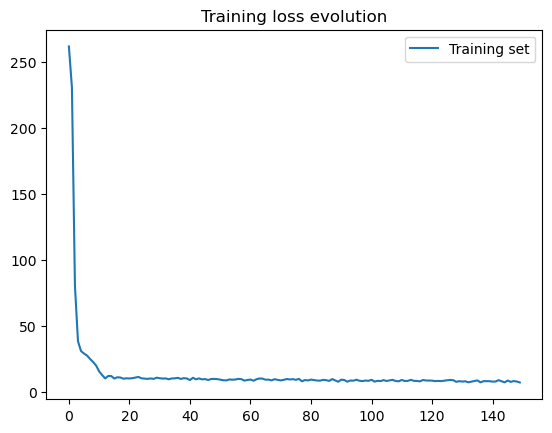

8/8 [==============================] - 1s 5ms/step
RMSE: 1.3940258589289023 R2: 0.8294335026478334


In [37]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
import keras
import tensorflow as tf
# set seed: 
tf.keras.utils.set_random_seed(31)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()
#22 the best!!
# 29 now the best!

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train)
X_test_daily_scaled = scaler.transform(X_test)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(GRU(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


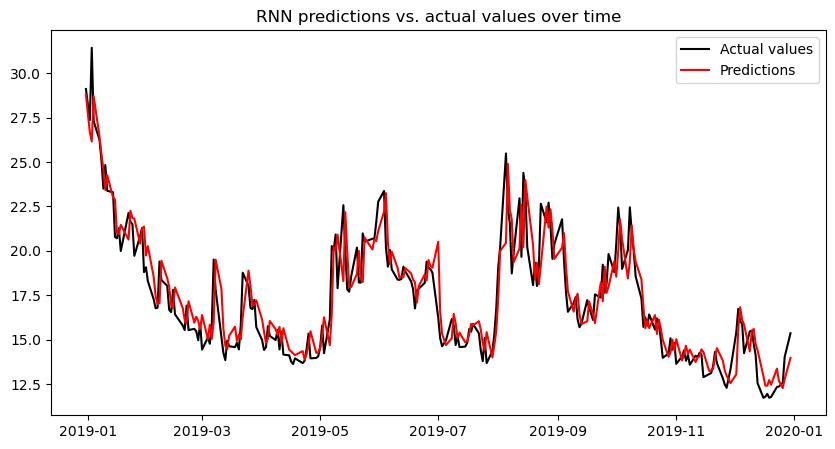

In [71]:
#plot prediction vs actual over time:
plt.figure(figsize=(10,5))
plt.plot(test_dates, y_test, color = 'black')
plt.plot(test_dates, y_pred, color='red')
plt.title('RNN predictions vs. actual values over time')
plt.legend(['Actual values', 'Predictions'])
plt.show()

Lowest RMSE so far!!

In [52]:
X_train.columns

Index(['Volatility_lag1', 'stock_log_returns_lag1', 'stock_volume_lag1',
       'US_log_inflation_lag1', 'US_interest_rate_lag1',
       'consumer_barometer_lag1', 'weighted_sentiment_lag1'],
      dtype='object')

In [53]:
#now drop the interest rates and barometer stuff and see what it changes:
X_train3 = X_train[['Volatility_lag1', 'stock_log_returns_lag1', 'stock_volume_lag1',
       'US_log_inflation_lag1', 'weighted_sentiment_lag1']]
X_test3 = X_test[['Volatility_lag1', 'stock_log_returns_lag1', 'stock_volume_lag1',
       'US_log_inflation_lag1', 'weighted_sentiment_lag1']]

Epoch 1/150
16/16 [==============================] - 5s 16ms/step - loss: 263.1289
Epoch 2/150
16/16 [==============================] - 0s 20ms/step - loss: 250.5119
Epoch 3/150
16/16 [==============================] - 0s 15ms/step - loss: 154.0209
Epoch 4/150
16/16 [==============================] - 0s 15ms/step - loss: 37.6011
Epoch 5/150
16/16 [==============================] - 0s 19ms/step - loss: 35.7015
Epoch 6/150
16/16 [==============================] - 0s 13ms/step - loss: 30.2431
Epoch 7/150
16/16 [==============================] - 0s 11ms/step - loss: 33.0062
Epoch 8/150
16/16 [==============================] - 0s 14ms/step - loss: 31.4948
Epoch 9/150
16/16 [==============================] - 0s 13ms/step - loss: 30.0590
Epoch 10/150
16/16 [==============================] - 0s 15ms/step - loss: 29.0860
Epoch 11/150
16/16 [==============================] - 0s 15ms/step - loss: 28.0566
Epoch 12/150
16/16 [==============================] - 0s 14ms/step - loss: 23.6883
Epoch 13/1

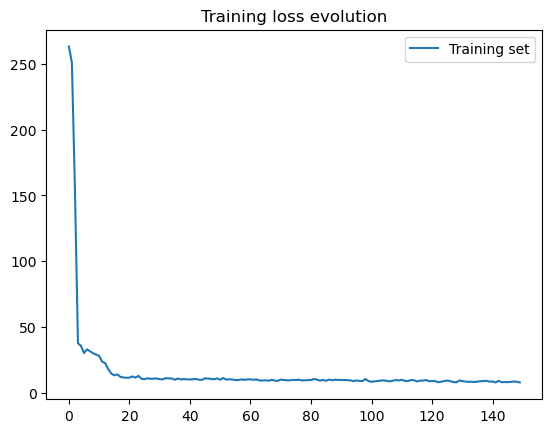

8/8 [==============================] - 1s 10ms/step
RMSE: 1.3976875077616397 R2: 0.8285362813200927


In [56]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
import keras

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train)
X_test_daily_scaled = scaler.transform(X_test)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(GRU(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


Epoch 1/150
16/16 [==============================] - 7s 22ms/step - loss: 263.2644
Epoch 2/150
16/16 [==============================] - 0s 22ms/step - loss: 251.0644
Epoch 3/150
16/16 [==============================] - 0s 22ms/step - loss: 156.7965
Epoch 4/150
16/16 [==============================] - 0s 22ms/step - loss: 40.8689
Epoch 5/150
16/16 [==============================] - 0s 22ms/step - loss: 24.7071
Epoch 6/150
16/16 [==============================] - 0s 19ms/step - loss: 22.1879
Epoch 7/150
16/16 [==============================] - 0s 20ms/step - loss: 22.0027
Epoch 8/150
16/16 [==============================] - 0s 20ms/step - loss: 21.8133
Epoch 9/150
16/16 [==============================] - 0s 19ms/step - loss: 21.7227
Epoch 10/150
16/16 [==============================] - 0s 27ms/step - loss: 21.9398
Epoch 11/150
16/16 [==============================] - 0s 20ms/step - loss: 21.5598
Epoch 12/150
16/16 [==============================] - 0s 20ms/step - loss: 22.2386
Epoch 13/1

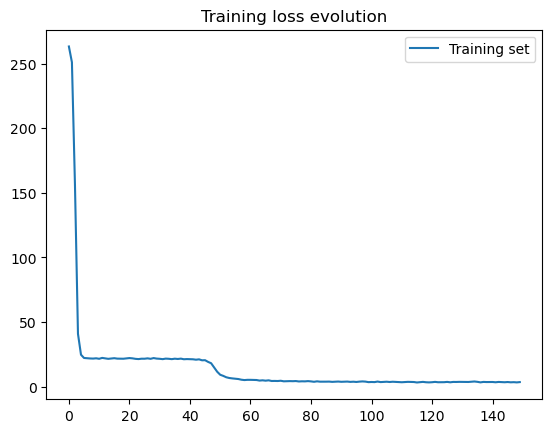

8/8 [==============================] - 1s 5ms/step
RMSE: 1.5095509993252296 R2: 0.799991869112243


In [59]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(96, activation='tanh', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(96, activation='tanh', return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(96, activation='tanh', return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(96, activation='tanh', return_sequences = False))
model.add(Dropout(0.25))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')


# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)





Add movement of the sentiment to the data, that is the difference between sentiment today and day before...

In [40]:
X_train.columns

Index(['Volatility_lag1', 'stock_log_returns_lag1', 'stock_volume_lag1',
       'US_log_inflation_lag1', 'US_interest_rate_lag1',
       'consumer_barometer_lag1', 'weighted_sentiment_lag1'],
      dtype='object')

In [54]:
X_train4 = X_train.copy()
X_train4['sentiment_movement'] = X_train4['weighted_sentiment_lag1'].diff()
X_train4.dropna(inplace=True)
X_train4.head()

X_test4 = X_test.copy()
X_test4['sentiment_movement'] = X_test4['weighted_sentiment_lag1'].diff()
X_test4.dropna(inplace=True)
X_test4.head()

,Volatility_lag1,stock_log_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1,weighted_sentiment_lag1,sentiment_movement
1006,29.11,0.708673,2.109320e+09,0.068466,3.0,0.062721,0.267217,0.061212
1007,27.36,0.486965,2.261800e+09,-0.081531,3.0,-0.556296,0.099231,-0.167985
1008,31.43,-3.417989,2.631550e+09,-0.081531,3.0,-0.556296,0.159462,0.060231
1009,27.29,4.384862,2.596150e+09,-0.081531,3.0,-0.556296,0.222765,0.063303
1010,26.25,1.015894,2.523450e+09,-0.081531,3.0,-0.556296,0.293124,0.070358


In [55]:
y_train4 = y_train[1:]
y_test4 = y_test[1:]

Epoch 1/150
16/16 [==============================] - 6s 13ms/step - loss: 262.5094
Epoch 2/150
16/16 [==============================] - 0s 13ms/step - loss: 238.2644
Epoch 3/150
16/16 [==============================] - 0s 13ms/step - loss: 106.7434
Epoch 4/150
16/16 [==============================] - 0s 13ms/step - loss: 40.2126
Epoch 5/150
16/16 [==============================] - 0s 13ms/step - loss: 36.7224
Epoch 6/150
16/16 [==============================] - 0s 13ms/step - loss: 32.6079
Epoch 7/150
16/16 [==============================] - 0s 15ms/step - loss: 31.5541
Epoch 8/150
16/16 [==============================] - 0s 16ms/step - loss: 35.2285
Epoch 9/150
16/16 [==============================] - 0s 15ms/step - loss: 29.8152
Epoch 10/150
16/16 [==============================] - 0s 16ms/step - loss: 30.9174
Epoch 11/150
16/16 [==============================] - 0s 17ms/step - loss: 29.9078
Epoch 12/150
16/16 [==============================] - 0s 16ms/step - loss: 28.1254
Epoch 13/1

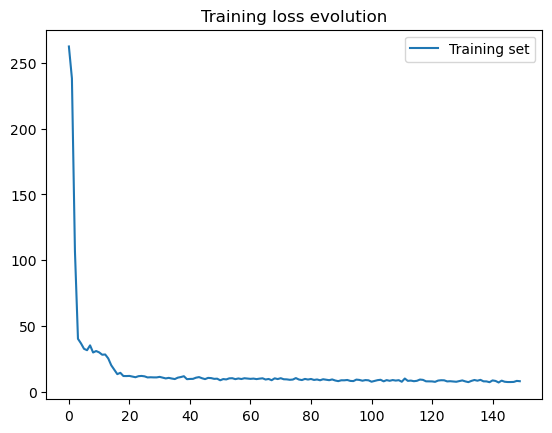

8/8 [==============================] - 1s 12ms/step
RMSE: 1.4389321240038804 R2: 0.809705419244722


In [57]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
import keras
import tensorflow as tf
# set seed: 
#tf.keras.utils.set_random_seed(31)  # sets seeds for base-python, numpy and tf
#tf.config.experimental.enable_op_determinism()
#22 the best!!
# 29 now the best!

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train4)
X_test_daily_scaled = scaler.transform(X_test4)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(GRU(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train4, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test4, y_pred))
r2_rnn = r2_score(y_test4, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


In [58]:
# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(70,80), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(75,85), 'learning_rate': np.linspace(0.08,0.12,10), 'max_depth': [1, 2, 3]}
}

# Storing model performance
model_performance = {}
model_predictions = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring='neg_mean_squared_error')
    param_search.fit(X_train4, y_train4)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test4)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test4, y_pred))
    r2 = r2_score(y_test4, y_pred)

    # Store results
    model_performance[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance)

Model:   Random Forest
{'n_estimators': range(70, 80), 'max_depth': range(1, 5)}
RandomForestRegressor(max_depth=4, n_estimators=73, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(75, 85), 'learning_rate': array([0.08      , 0.08444444, 0.08888889, 0.09333333, 0.09777778,
       0.10222222, 0.10666667, 0.11111111, 0.11555556, 0.12      ]), 'max_depth': [1, 2, 3]}
GradientBoostingRegressor(learning_rate=0.10666666666666666, max_depth=1,
                          n_estimators=83, random_state=42)
{'Random Forest': {'RMSE': 1.467138344930111, 'R2': 0.8021719182761088, 'Best Params': {'n_estimators': 73, 'max_depth': 4}}, 'Gradient Boosting': {'RMSE': 1.582584921757358, 'R2': 0.7698134990744132, 'Best Params': {'n_estimators': 83, 'max_depth': 1, 'learning_rate': 0.10666666666666666}}}


In [61]:
X_train4.columns

Index(['Volatility_lag1', 'stock_log_returns_lag1', 'stock_volume_lag1',
       'US_log_inflation_lag1', 'US_interest_rate_lag1',
       'consumer_barometer_lag1', 'weighted_sentiment_lag1',
       'sentiment_movement'],
      dtype='object')

In [64]:
X_train5 = X_train4[['Volatility_lag1', 'weighted_sentiment_lag1','sentiment_movement' ]]
X_test5 = X_test4[['Volatility_lag1', 'weighted_sentiment_lag1','sentiment_movement' ]]

In [65]:
# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(70,80), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(75,85), 'learning_rate': np.linspace(0.08,0.12,10), 'max_depth': [1, 2, 3]}
}

# Storing model performance
model_performance = {}
model_predictions = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring='neg_mean_squared_error')
    param_search.fit(X_train5, y_train4)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test5)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test4, y_pred))
    r2 = r2_score(y_test4, y_pred)

    # Store results
    model_performance[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance)

Model:   Random Forest
{'n_estimators': range(70, 80), 'max_depth': range(1, 5)}
RandomForestRegressor(max_depth=4, n_estimators=76, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(75, 85), 'learning_rate': array([0.08      , 0.08444444, 0.08888889, 0.09333333, 0.09777778,
       0.10222222, 0.10666667, 0.11111111, 0.11555556, 0.12      ]), 'max_depth': [1, 2, 3]}
GradientBoostingRegressor(learning_rate=0.11555555555555555, max_depth=2,
                          n_estimators=75, random_state=42)
{'Random Forest': {'RMSE': 1.4356591435228547, 'R2': 0.8105701189705172, 'Best Params': {'n_estimators': 76, 'max_depth': 4}}, 'Gradient Boosting': {'RMSE': 1.4800234877536433, 'R2': 0.7986818090003317, 'Best Params': {'n_estimators': 75, 'max_depth': 2, 'learning_rate': 0.11555555555555555}}}


(barely) but lower rmse than for x_train2 for the random forest....

Epoch 1/150
16/16 [==============================] - 4s 12ms/step - loss: 262.0246
Epoch 2/150
16/16 [==============================] - 0s 12ms/step - loss: 246.4001
Epoch 3/150
16/16 [==============================] - 0s 12ms/step - loss: 154.2674
Epoch 4/150
16/16 [==============================] - 0s 13ms/step - loss: 41.3646
Epoch 5/150
16/16 [==============================] - 0s 12ms/step - loss: 31.3154
Epoch 6/150
16/16 [==============================] - 0s 13ms/step - loss: 25.4894
Epoch 7/150
16/16 [==============================] - 0s 15ms/step - loss: 22.5912
Epoch 8/150
16/16 [==============================] - 0s 13ms/step - loss: 18.4833
Epoch 9/150
16/16 [==============================] - 0s 13ms/step - loss: 15.1804
Epoch 10/150
16/16 [==============================] - 0s 13ms/step - loss: 12.4663
Epoch 11/150
16/16 [==============================] - 0s 17ms/step - loss: 10.7776
Epoch 12/150
16/16 [==============================] - 0s 13ms/step - loss: 10.0547
Epoch 13/1

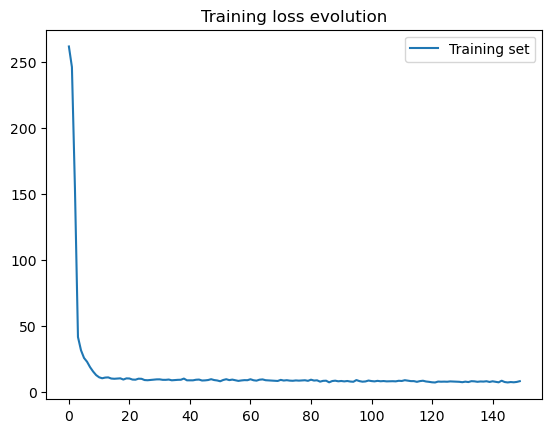

8/8 [==============================] - 2s 6ms/step
RMSE: 1.4036174057230049 R2: 0.818931337255931


In [69]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
import keras
import tensorflow as tf
# set seed: 
#tf.keras.utils.set_random_seed(31)  # sets seeds for base-python, numpy and tf
#tf.config.experimental.enable_op_determinism()
#22 the best!!
# 29 now the best!

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train5)
X_test_daily_scaled = scaler.transform(X_test5)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(LSTM(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train4, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test4, y_pred))
r2_rnn = r2_score(y_test4, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


In [71]:
#!pip install keras_tuner

  Obtaining dependency information for keras_tuner from https://files.pythonhosted.org/packages/db/5d/945296512980b0827e93418514c8be9236baa6f0a1e8ca8be3a2026665b0/keras_tuner-1.4.7-py3-none-any.whl.metadata
  Obtaining dependency information for kt-legacy from https://files.pythonhosted.org/packages/16/53/aca9f36da2516db008017db85a1f3cafaee0efc5fc7a25d94c909651792f/kt_legacy-1.0.5-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ------------ -------------------------- 41.0/129.1 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [73]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam

def build_model(hp):
    model = Sequential()
    model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences=True))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of different configurations to try
    executions_per_trial=3,  # Number of models to train for each configuration
#    directory='my_dir',  # Directory to save logs
#    project_name='dropout_tuning'
)

tuner.search(X_train_daily_scaled, y_train4, epochs=50, validation_split=0.2, verbose=1, shuffle = False)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best dropout rate at first layer: {best_hps.get('dropout_1')}")
print(f"Best dropout rate at second layer: {best_hps.get('dropout_2')}")


Trial 10 Complete [00h 02m 40s]
val_loss: 4.623396873474121

Best val_loss So Far: 3.899820566177368
Total elapsed time: 00h 19m 21s
Best dropout rate at first layer: 0.2
Best dropout rate at second layer: 0.2


Epoch 1/150
16/16 [==============================] - 4s 19ms/step - loss: 261.6026
Epoch 2/150
16/16 [==============================] - 0s 17ms/step - loss: 243.8777
Epoch 3/150
16/16 [==============================] - 0s 18ms/step - loss: 143.2962
Epoch 4/150
16/16 [==============================] - 0s 17ms/step - loss: 37.7281
Epoch 5/150
16/16 [==============================] - 0s 16ms/step - loss: 27.8245
Epoch 6/150
16/16 [==============================] - 0s 18ms/step - loss: 23.0019
Epoch 7/150
16/16 [==============================] - 0s 17ms/step - loss: 20.7347
Epoch 8/150
16/16 [==============================] - 0s 17ms/step - loss: 17.6537
Epoch 9/150
16/16 [==============================] - 0s 19ms/step - loss: 12.7687
Epoch 10/150
16/16 [==============================] - 0s 18ms/step - loss: 10.3275
Epoch 11/150
16/16 [==============================] - 0s 17ms/step - loss: 8.7096
Epoch 12/150
16/16 [==============================] - 0s 16ms/step - loss: 8.4412
Epoch 13/150

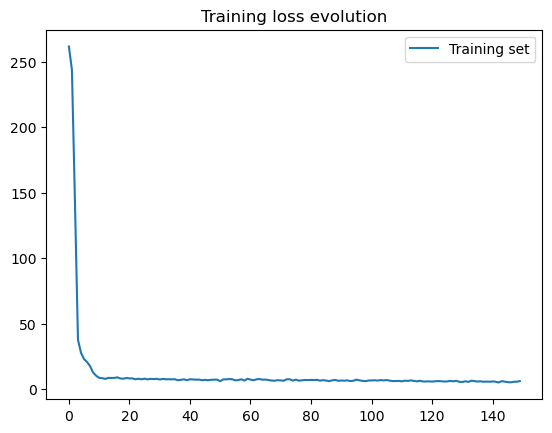

8/8 [==============================] - 1s 5ms/step
RMSE: 1.4184829828112762 R2: 0.8150756656616363


In [75]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
import keras
import tensorflow as tf
# set seed: 
#tf.keras.utils.set_random_seed(31)  # sets seeds for base-python, numpy and tf
#tf.config.experimental.enable_op_determinism()
#22 the best!!
# 29 now the best!

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train5)
X_test_daily_scaled = scaler.transform(X_test5)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(LSTM(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train4, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test4, y_pred))
r2_rnn = r2_score(y_test4, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        hp.Int('units_lstm1', min_value=50, max_value=300, step=50),
        activation='relu',
        input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]),
        return_sequences=True
    ))
    model.add(LSTM(
        hp.Int('units_lstm2', min_value=50, max_value=300, step=50),
        return_sequences=True
    ))
    model.add(LSTM(
        hp.Int('units_lstm3', min_value=50, max_value=300, step=50),
        return_sequences=False
    ))
    model.add(Dense(
        hp.Int('units_dense1', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dropout(0.2))  # Optimal dropout rate from previous tuning
    model.add(Dense(
        hp.Int('units_dense2', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dropout(0.2))  # Optimal dropout rate from previous tuning
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=1e-3, decay=1e-4, clipvalue=1),
        loss='mean_squared_error'
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=3,
    executions_per_trial=2,
    directory='my_dir',
    project_name='unit_tuning'
)

tuner.search(X_train_daily_scaled, y_train4, epochs=50, validation_split=0.2, verbose=1, shuffle=False)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best number of units in LSTM layer 1: {best_hps.get('units_lstm1')}")
print(f"Best number of units in LSTM layer 2: {best_hps.get('units_lstm2')}")
print(f"Best number of units in LSTM layer 3: {best_hps.get('units_lstm3')}")
print(f"Best number of units in Dense layer 1: {best_hps.get('units_dense1')}")
print(f"Best number of units in Dense layer 2: {best_hps.get('units_dense2')}")

Trial 3 Complete [00h 01m 19s]
val_loss: 5.732531309127808

Best val_loss So Far: 3.4493906497955322
Total elapsed time: 00h 06m 00s
Best number of units in LSTM layer 1: 250
Best number of units in LSTM layer 2: 100
Best number of units in LSTM layer 3: 200
Best number of units in Dense layer 1: 128
Best number of units in Dense layer 2: 64


Epoch 1/150
16/16 [==============================] - 4s 19ms/step - loss: 261.1442
Epoch 2/150
16/16 [==============================] - 0s 19ms/step - loss: 219.6548
Epoch 3/150
16/16 [==============================] - 0s 19ms/step - loss: 59.9993
Epoch 4/150
16/16 [==============================] - 0s 20ms/step - loss: 25.6973
Epoch 5/150
16/16 [==============================] - 0s 19ms/step - loss: 20.1204
Epoch 6/150
16/16 [==============================] - 0s 20ms/step - loss: 17.0638
Epoch 7/150
16/16 [==============================] - 0s 23ms/step - loss: 12.0587
Epoch 8/150
16/16 [==============================] - 0s 23ms/step - loss: 10.0873
Epoch 9/150
16/16 [==============================] - 0s 22ms/step - loss: 6.5684
Epoch 10/150
16/16 [==============================] - 0s 25ms/step - loss: 6.9875
Epoch 11/150
16/16 [==============================] - 0s 23ms/step - loss: 7.0429
Epoch 12/150
16/16 [==============================] - 0s 21ms/step - loss: 7.0950
Epoch 13/150
16

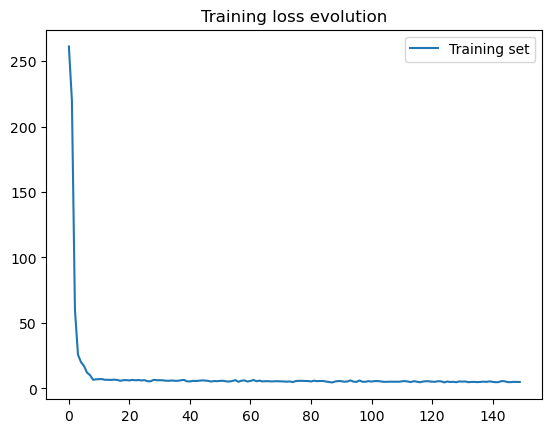

8/8 [==============================] - 1s 5ms/step
RMSE: 1.3705369011398554 R2: 0.8273656275278718


In [92]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
import keras
import tensorflow as tf
# set seed: 
#tf.keras.utils.set_random_seed(31)  # sets seeds for base-python, numpy and tf
#tf.config.experimental.enable_op_determinism()
#22 the best!!
# 29 now the best!

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train5)
X_test_daily_scaled = scaler.transform(X_test5)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(250, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(LSTM(100, return_sequences = True))
model.add(LSTM(200, return_sequences = False))
model.add(Dense(128, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train4, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test4, y_pred))
r2_rnn = r2_score(y_test4, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


Epoch 1/150
16/16 [==============================] - 4s 25ms/step - loss: 254.9370
Epoch 2/150
16/16 [==============================] - 0s 24ms/step - loss: 128.7171
Epoch 3/150
16/16 [==============================] - 0s 25ms/step - loss: 38.6700
Epoch 4/150
16/16 [==============================] - 0s 24ms/step - loss: 24.6118
Epoch 5/150
16/16 [==============================] - 0s 24ms/step - loss: 19.1540
Epoch 6/150
16/16 [==============================] - 0s 25ms/step - loss: 17.1811
Epoch 7/150
16/16 [==============================] - 0s 25ms/step - loss: 13.2366
Epoch 8/150
16/16 [==============================] - 0s 25ms/step - loss: 10.0831
Epoch 9/150
16/16 [==============================] - 0s 26ms/step - loss: 6.5908
Epoch 10/150
16/16 [==============================] - 0s 25ms/step - loss: 6.0327
Epoch 11/150
16/16 [==============================] - 0s 25ms/step - loss: 5.8017
Epoch 12/150
16/16 [==============================] - 0s 25ms/step - loss: 5.8721
Epoch 13/150
16

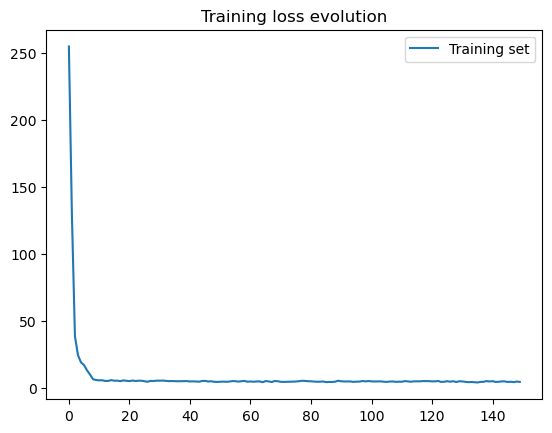

8/8 [==============================] - 1s 6ms/step
RMSE: 1.3874232006342477 R2: 0.823085386054857


In [94]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers.legacy import Adam
import keras
import tensorflow as tf
# set seed: 
#tf.keras.utils.set_random_seed(31)  # sets seeds for base-python, numpy and tf
#tf.config.experimental.enable_op_determinism()
#22 the best!!
# 29 now the best!

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train5)
X_test_daily_scaled = scaler.transform(X_test5)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(250, activation='tanh', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(LSTM(100, return_sequences = True))
model.add(LSTM(200, return_sequences = False))
model.add(Dense(128, activation='tanh'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train4, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test4, y_pred))
r2_rnn = r2_score(y_test4, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


In [84]:
#method from ISLP, first start with linear regression as a benchmark:
from sklearn.linear_model import LinearRegression
M = LinearRegression()
M.fit(X_train, y_train)
M.score(X_test, y_test)

0.8292577367111014

In [85]:
y_pred = M.predict(X_test)
r2_score(y_test, y_pred)

0.8292577367111014

In [86]:
np.sqrt(mean_squared_error(y_test,y_pred))

1.394743934208597

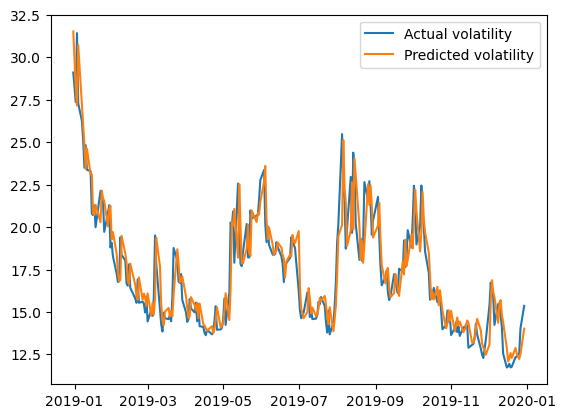

In [89]:
plt.plot(test_dates, y_test, label = 'Actual volatility')
plt.plot(test_dates, y_pred, label = 'Predicted volatility')
plt.legend()

Epoch 1/200
16/16 [==============================] - 1s 1ms/step - loss: 280.8129
Epoch 2/200
16/16 [==============================] - 0s 2ms/step - loss: 268.7761
Epoch 3/200
16/16 [==============================] - 0s 2ms/step - loss: 259.3562
Epoch 4/200
16/16 [==============================] - 0s 2ms/step - loss: 249.4577
Epoch 5/200
16/16 [==============================] - 0s 2ms/step - loss: 240.4124
Epoch 6/200
16/16 [==============================] - 0s 2ms/step - loss: 231.8992
Epoch 7/200
16/16 [==============================] - 0s 1ms/step - loss: 223.1484
Epoch 8/200
16/16 [==============================] - 0s 2ms/step - loss: 214.4121
Epoch 9/200
16/16 [==============================] - 0s 2ms/step - loss: 206.1415
Epoch 10/200
16/16 [==============================] - 0s 2ms/step - loss: 198.4863
Epoch 11/200
16/16 [==============================] - 0s 2ms/step - loss: 190.2010
Epoch 12/200
16/16 [==============================] - 0s 2ms/step - loss: 181.6252
Epoch 13/200


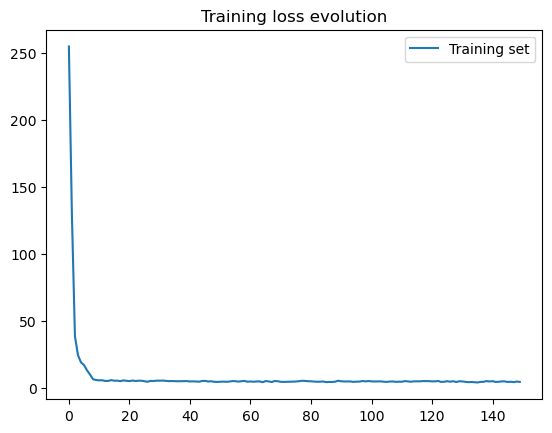

8/8 [==============================] - 0s 2ms/step
RMSE: 1.471894431517424 R2: 0.809846030486078


In [104]:
#ISLP model:
import tensorflow as tf
# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train)
X_test_daily_scaled = scaler.transform(X_test)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))


class ISLP(tf.keras.Model):
    def __init__(self):
        super(ISLP, self).__init__()
        self.rnn = tf.keras.layers.SimpleRNN(12, return_sequences=True)
        self.dense = tf.keras.layers.Dense(1)
        self.dropout = tf.keras.layers.Dropout(0.1)
        
    def call(self, x):
        val = self.rnn(x)
        val = self.dense(self.dropout(val[:, -1]))
        return tf.reshape(val, [-1])

islp_model = ISLP()

islp_model.compile(optimizer='RMSprop', loss='mean_squared_error')
islp_model.fit(X_train_daily_scaled, y_train, epochs = 200, batch_size=64)
islp_model.summary()


plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = islp_model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


SVM!!!!!!

In [107]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVR
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

Do the AR as input for neural net like ISLP book!!!

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

y_pred = model.predict(X_test_scaled)

--------------------------------------------------------------------------------------

### Models with new sentiment index:

In [5]:
sentiment_index_log_weighed_df = pd.read_excel('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/index/sentiment_index_log_weighted.xlsx')

sentiment_index_log_weighed_df.head()

,date,sentiment_score
0,2015-01-02,0.149896
1,2015-01-05,0.185542
2,2015-01-06,0.165909
3,2015-01-07,0.182038
4,2015-01-08,0.226006


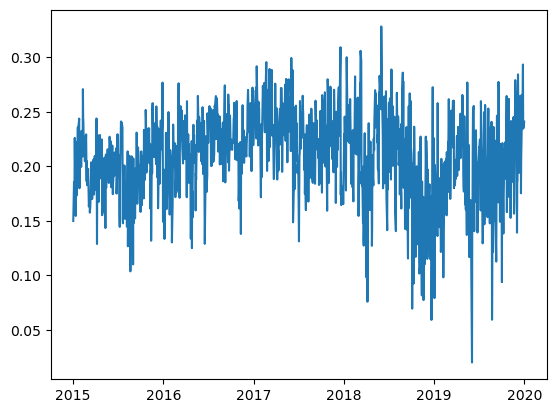

In [6]:
plt.plot(sentiment_index_log_weighed_df['date'], sentiment_index_log_weighed_df['sentiment_score'])

In [7]:
sentiment_index_log_weighed_df.rename(columns={'date' : 'Date'}, inplace=True)

In [16]:
merged_df = pd.merge(merged_df, 
                     sentiment_index_log_weighed_df[['Date', 'sentiment_score']], 
                     on='Date', 
                     how='inner')
merged_df.head()

,Date,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer,sentiment_score
0,2015-01-02,16.59,-0.142669,1435150000,-0.639069,0.75,0.353886,0.149896
1,2015-01-05,18.00,-1.651298,1794470000,-0.639069,0.75,0.353886,0.185542
2,2015-01-06,19.05,-1.212083,2167320000,-0.639069,0.75,0.353886,0.165909
3,2015-01-07,17.20,1.189010,1957950000,-0.639069,0.75,0.353886,0.182038
4,2015-01-08,16.61,1.917786,2105450000,-0.639069,0.75,0.353886,0.226006


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#Creating Lagged Features
#lags = 1  # Number of lags
#for column in merged_df.columns.drop('Date'):
#    for lag in range(1, lags + 1):
#        merged_df[f'{column}_lag{lag}'] = merged_df[column].shift(lag)

# Dropping rows with NaN values after shifting
#merged_df.dropna(inplace=True)

#merged_df.head()

,Date,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer,sentiment_score,Volatility_lag1,stock_log_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1,sentiment_score_lag1
1,2015-01-05,18.00,-1.651298,1794470000,-0.639069,0.75,0.353886,0.185542,16.59,-0.142669,1.435150e+09,-0.639069,0.75,0.353886,0.149896
2,2015-01-06,19.05,-1.212083,2167320000,-0.639069,0.75,0.353886,0.165909,18.00,-1.651298,1.794470e+09,-0.639069,0.75,0.353886,0.185542
3,2015-01-07,17.20,1.189010,1957950000,-0.639069,0.75,0.353886,0.182038,19.05,-1.212083,2.167320e+09,-0.639069,0.75,0.353886,0.165909
4,2015-01-08,16.61,1.917786,2105450000,-0.639069,0.75,0.353886,0.226006,17.20,1.189010,1.957950e+09,-0.639069,0.75,0.353886,0.182038
5,2015-01-09,16.60,-0.645154,1715830000,-0.639069,0.75,0.353886,0.203986,16.61,1.917786,2.105450e+09,-0.639069,0.75,0.353886,0.226006


In [18]:
#create X_train, y_train, X_test and y_test:
X_train, X_test, y_train, y_test = train_test_split(merged_df.loc[:, merged_df.columns != 'Date'], merged_df['Volatility'], test_size=0.2, shuffle=False)
X_train = X_train[['Volatility_lag1','stock_log_returns_lag1', 
                       'stock_volume_lag1', 'US_log_inflation_lag1',
                       'US_interest_rate_lag1', 'consumer_barometer_lag1', 'sentiment_score_lag1']]

X_test = X_test[['Volatility_lag1','stock_log_returns_lag1', 
                       'stock_volume_lag1', 'US_log_inflation_lag1',
                       'US_interest_rate_lag1', 'consumer_barometer_lag1', 'sentiment_score_lag1']]

X_train.head()

,Volatility_lag1,stock_log_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1,sentiment_score_lag1
1,16.59,-0.142669,1.435150e+09,-0.639069,0.75,0.353886,0.149896
2,18.00,-1.651298,1.794470e+09,-0.639069,0.75,0.353886,0.185542
3,19.05,-1.212083,2.167320e+09,-0.639069,0.75,0.353886,0.165909
4,17.20,1.189010,1.957950e+09,-0.639069,0.75,0.353886,0.182038
5,16.61,1.917786,2.105450e+09,-0.639069,0.75,0.353886,0.226006


In [22]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(70,80), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(75,85), 'learning_rate': np.linspace(0.08,0.12,10), 'max_depth': [1, 2, 3]}
}

# Storing model performance
model_performance = {}
model_predictions = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring='neg_mean_squared_error')
    param_search.fit(X_train, y_train)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_performance[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance)

Model:   Random Forest
{'n_estimators': range(70, 80), 'max_depth': range(1, 5)}
RandomForestRegressor(max_depth=4, n_estimators=76, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(75, 85), 'learning_rate': array([0.08      , 0.08444444, 0.08888889, 0.09333333, 0.09777778,
       0.10222222, 0.10666667, 0.11111111, 0.11555556, 0.12      ]), 'max_depth': [1, 2, 3]}
GradientBoostingRegressor(learning_rate=0.1111111111111111, max_depth=1,
                          n_estimators=80, random_state=42)
{'Random Forest': {'RMSE': 1.4805419718868769, 'R2': 0.8076051163256665, 'Best Params': {'n_estimators': 76, 'max_depth': 4}}, 'Gradient Boosting': {'RMSE': 1.5747433097971928, 'R2': 0.7823435130623401, 'Best Params': {'n_estimators': 80, 'max_depth': 1, 'learning_rate': 0.1111111111111111}}}


previous sentiment score results: 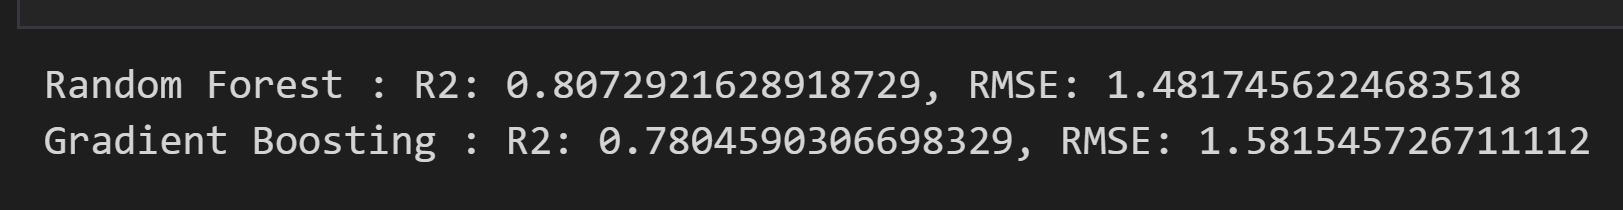